In [1]:
from qiskit import *
import numpy as np

from qiskit.visualization import plot_histogram
from qiskit import IBMQ, Aer
from scipy.optimize import minimize
from qiskit.providers.fake_provider import FakeToronto

IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

In [2]:
def QAOA_Vertex_Cover(connections,gamma,beta):
    n=max(map(max, connections))+1
    qc=QuantumCircuit(n+1,n)


    qc.x(n)
    qc.h(range(n))
    
    
    qc.barrier()
    for i in connections:
        qc.cp(-1*gamma,i,n)
        qc.mcp(gamma,i,n)

        
    qc.barrier()


    for i in range(n):
        qc.x(i)
        qc.cp(-1*gamma,i,n)
        qc.x(i)


    qc.barrier()


    qc.rx(2*beta, range(n))


    qc.measure(range(n),range(n))

    return qc




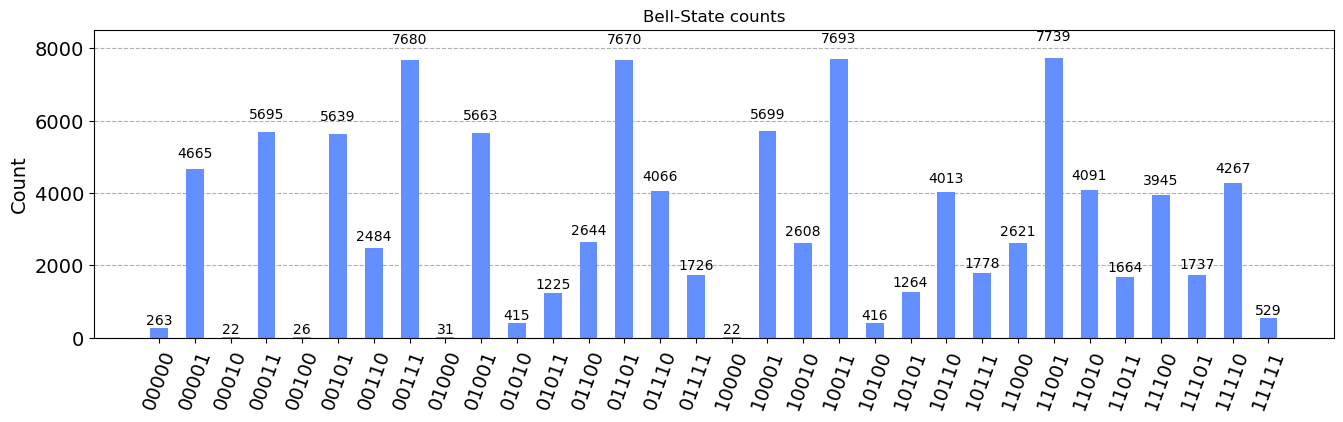

In [3]:
connections=[[0,1],[0,2],[0,3],[0,4],[1,3],[2,4]]
#gamma=[0,2pi], beta=[0,pi], gamma1<gamma2

gamma=np.pi*7/4
beta=np.pi*3.5/4
qc=QAOA_Vertex_Cover(connections,gamma,beta)

qc.draw()

backend = Aer.get_backend('aer_simulator')
circ = transpile(qc, backend)

# Run and get counts
#result = simulator.run(circ,shots=100000).result()
#counts = result.get_counts(circ)
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, title='Bell-State counts',figsize=(16,4))

In [4]:
class graph:
    def __init__(self, _graph=None):
        if _graph is None:
            _graph = {}
        self._graph = _graph
      
    def getVertices(self):
        return list(self._graph.keys())
    
    def printVertices(self):
        print(self.getVertices())
    
    def getEdges(self):
        edgename = []
        for vrtx in self._graph:
            for nxtvrtx in self._graph[vrtx]:
                if {nxtvrtx, vrtx} not in edgename:
                    edgename.append({vrtx, nxtvrtx})
        ret_list = []
        for i in range(len(edgename)):
            ret_list.append([])
            for j in edgename[i]:
                ret_list[i].append(j)
        return ret_list
    
    def printEdges(self):
        print(self.getEdges())
        
    def getGraph(self):
        return self._graph
    
    def make_graph_from_connections(self, connections):
        vertexs = []
        graph_dict = {}
        for edge_list in connections:
            for vertex in edge_list:
                if vertex not in vertexs:
                    vertexs.append(vertex)
                    
        for vertex in vertexs:
            graph_dict[vertex] = []
            
        for edge_list in connections:
            if edge_list[1] not in graph_dict[edge_list[0]]:
                graph_dict[edge_list[0]].append(edge_list[1])
                
            if edge_list[0] not in graph_dict[edge_list[1]]:
                graph_dict[edge_list[1]].append(edge_list[0])
                
        self._graph = graph_dict
        
    def printGraph(self):
        print(self._graph)
          
    

In [5]:
g = graph()
g.make_graph_from_connections(connections)
g.printEdges()
g.printVertices()
g.printGraph()

[[0, 1], [0, 2], [0, 3], [0, 4], [1, 3], [2, 4]]
[0, 1, 2, 3, 4]
{0: [1, 2, 3, 4], 1: [0, 3], 2: [0, 4], 3: [0, 1], 4: [0, 2]}


In [6]:
def mvc_obj(bitstring, graph):
    obj1 = 0
    obj2 = 0
    
    for i in range(len(bitstring)):
        if bitstring[i] == '0':
            obj1 -= 1
    
    connections = graph.getEdges()
    for vtx in connections:
        if bitstring[vtx[0]] == '1' or bitstring[vtx[1]] == '1':
            obj2 -= 1
        
    return obj1 + (obj2*1.2)

def compute_expectation(counts, graph):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = mvc_obj(bitstring[::-1], graph)
        avg += obj*count
        sum_count += count
    
    return avg/sum_count


def get_expectation(graph, backend, shots=100000):
    #simulator = Aer.get_backend('aer_simulator')
    backend.shots = shots
    connections = graph.getEdges()
            
    def execute_circ(theta):
        
        qc = QAOA_Vertex_Cover(connections,theta[0],theta[1])
        circ = transpile(qc, backend)
        counts = backend.run(circ,shots).result().get_counts()
        return compute_expectation(counts, graph)
    
    return execute_circ
    

# Testing on aer_simulator backend

In [7]:
backend = Aer.get_backend('aer_simulator')

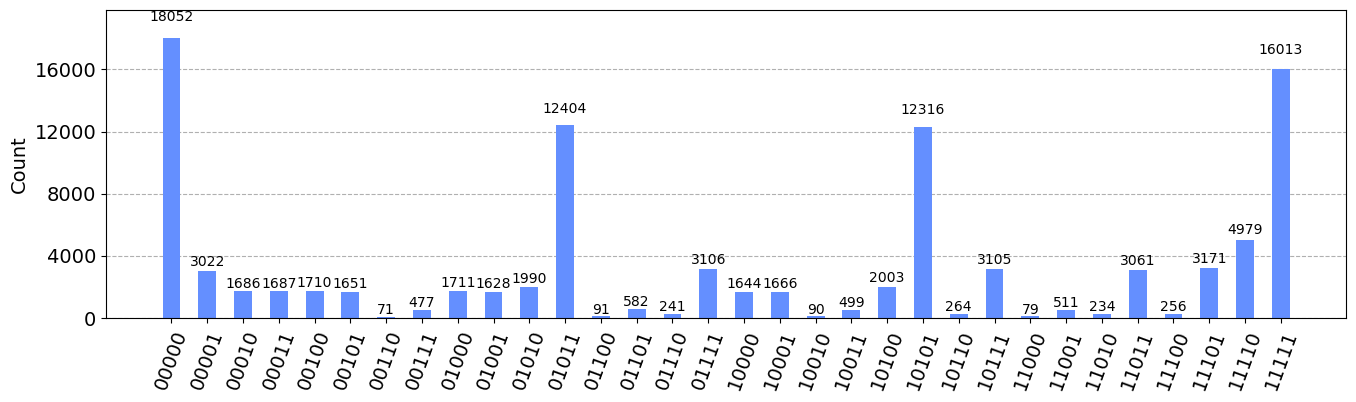

In [8]:
gamma=5
beta=2
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(connections,gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 7.135513223481054 ,Beta Pre-Otimization: 2 ,Beta Post-Optimization: 3.5733588694442284


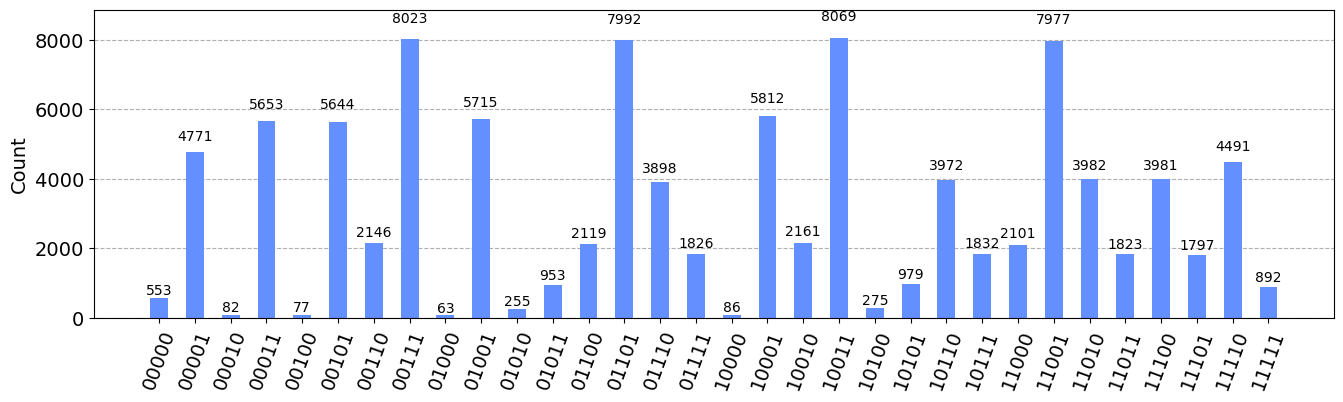

In [9]:
gamma=5
beta=2
theta = [gamma, beta]
expectation = get_expectation(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

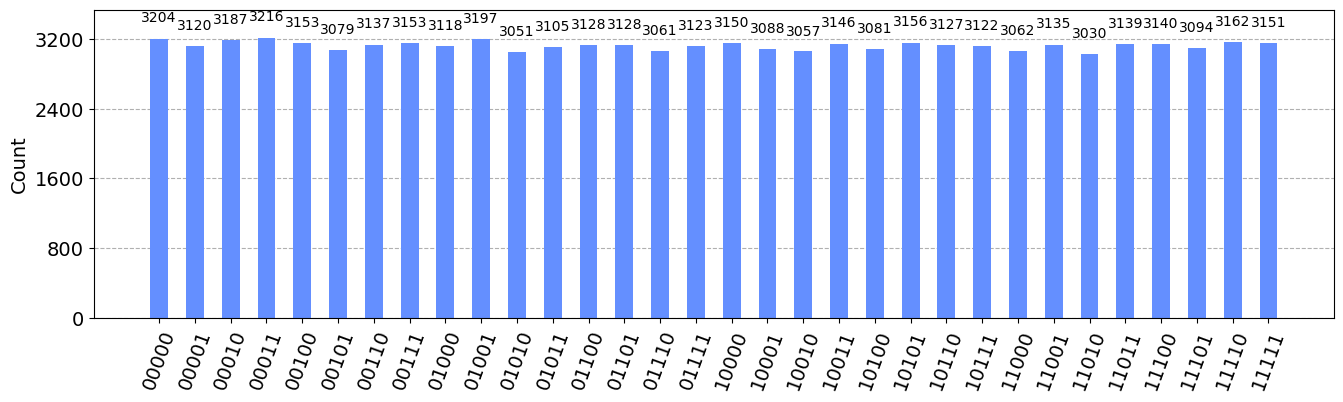

In [10]:
gamma=0
beta=0
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(connections,gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 0 ,Gamma Post-Otimization: -0.7035462470806833 ,Beta Pre-Otimization: 0 ,Beta Post-Optimization: -0.4583172896903843


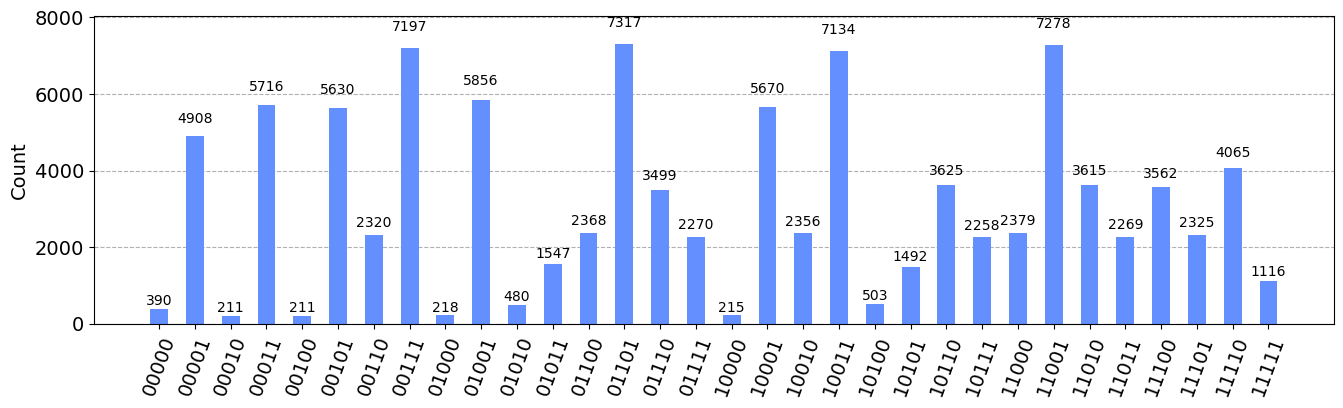

In [11]:
gamma=0
beta=0
theta = [gamma, beta]
expectation = get_expectation(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

In [12]:
graph2_dict = {
    0: [2,4],
    1: [2],
    2: [0,1,3],
    3: [2],
    4: [0]
}
g2 = graph(graph2_dict)
print(g2.getEdges())

[[0, 2], [0, 4], [1, 2], [2, 3]]


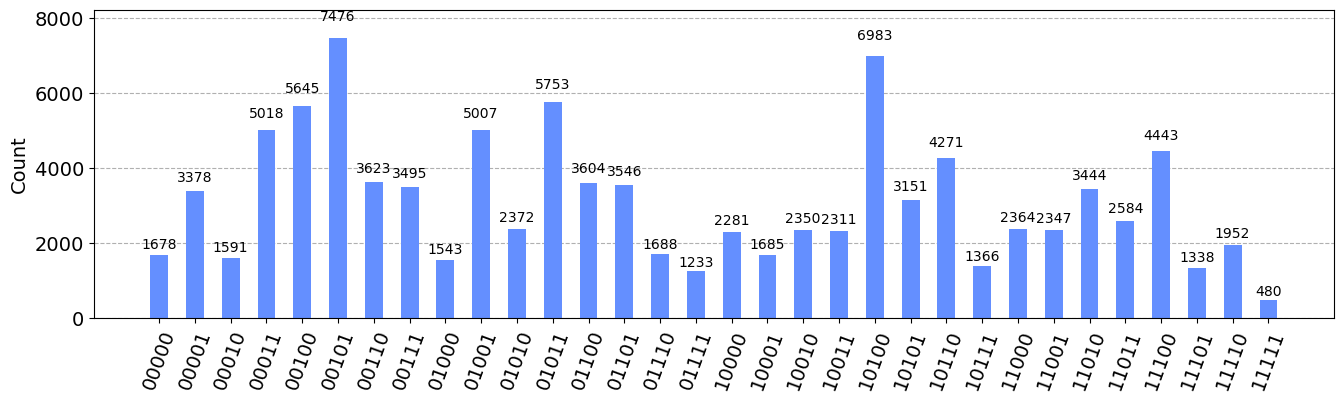

In [13]:
gamma=5
beta=3
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g2.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 4.6745929848532946 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 2.683614491577601


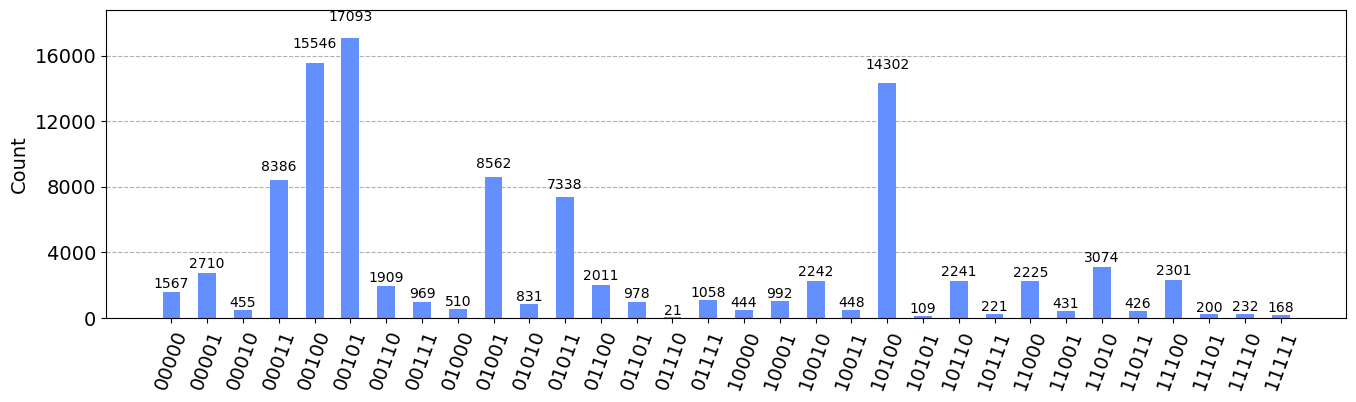

In [14]:
gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation(g2, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g2.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

In [15]:
graph3_dict = {
    0: [1,2],
    1: [0],
    2: [0,3],
    3: [2],
}
g3 = graph(graph3_dict)
print(g3.getEdges())

[[0, 1], [0, 2], [2, 3]]


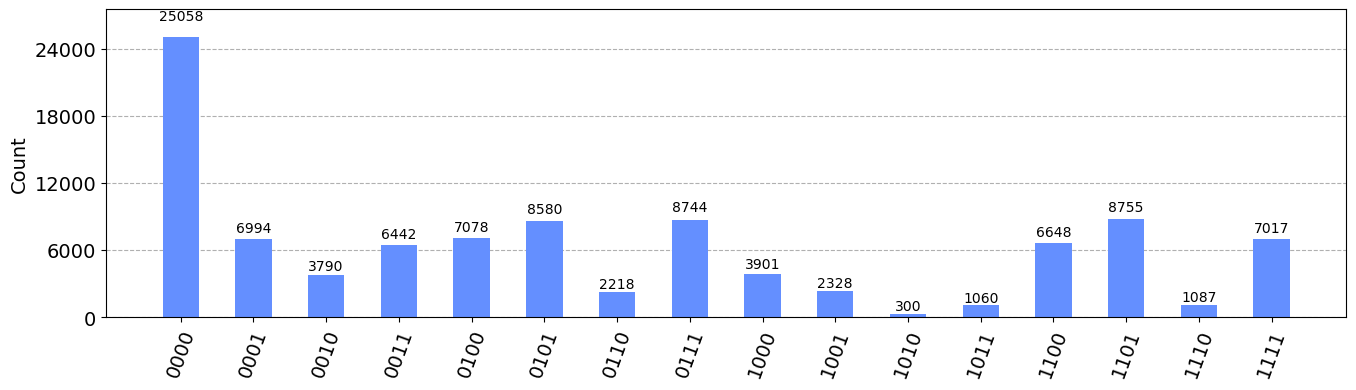

In [16]:
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g3.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 1.0755039842096494 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.9446173372633149


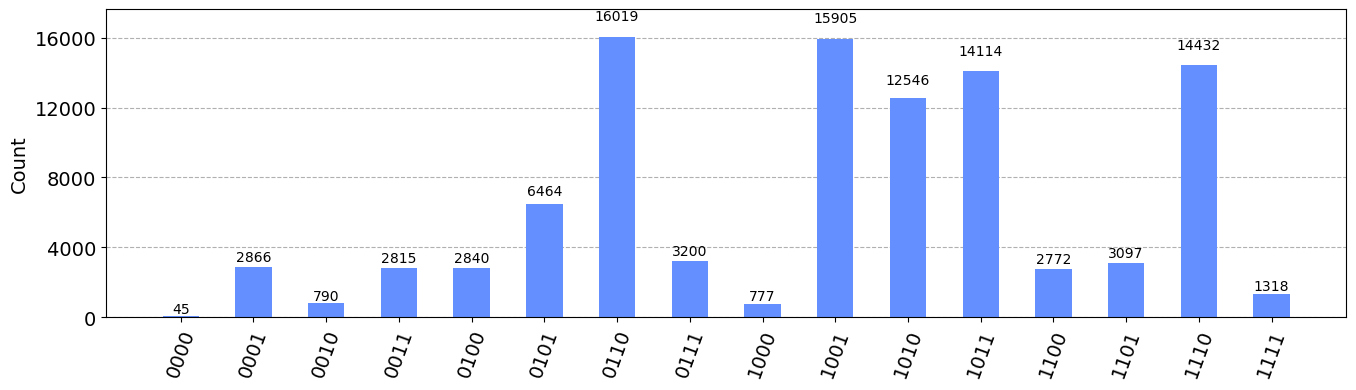

In [17]:
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g3, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

In [18]:
graph4_dict = {
    0: [3],
    1: [4],
    2: [5],
    3: [0,4],
    4: [1,3,5],
    5: [2,4]
}
g4 = graph(graph4_dict)
print(g4.getEdges())

[[0, 3], [1, 4], [2, 5], [3, 4], [4, 5]]


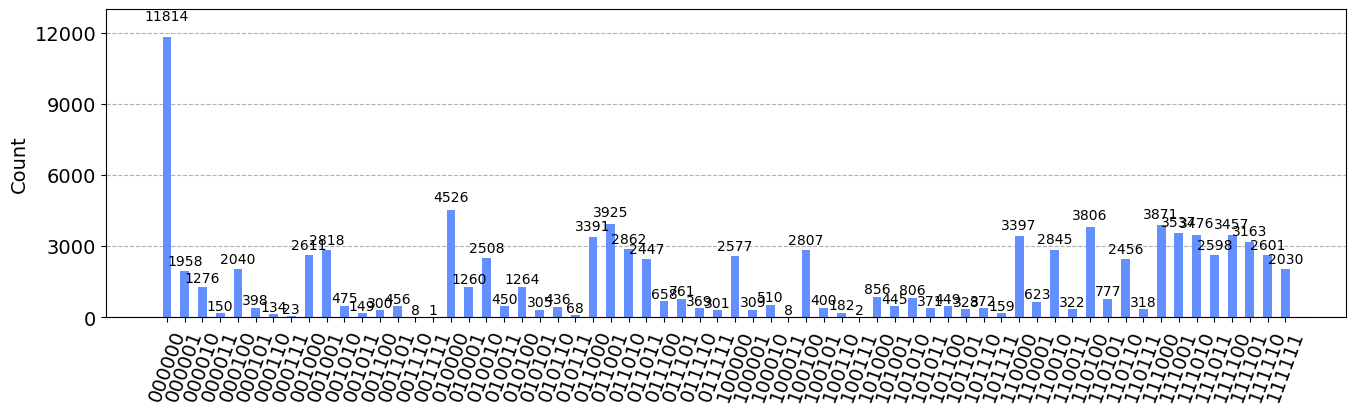

In [19]:
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g4.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 0.9442308573810151 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.8971416494794906


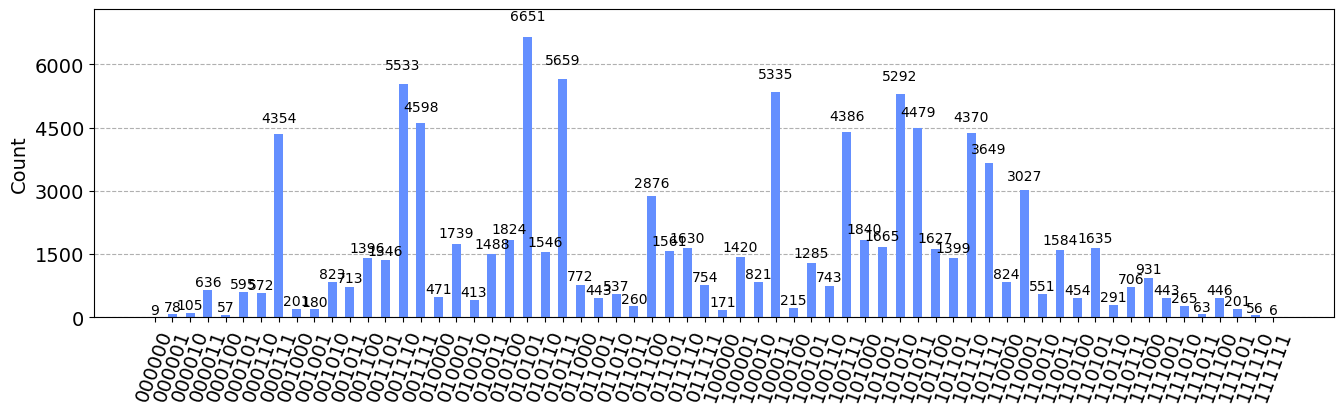

In [20]:
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts,figsize=(16,4))

In [21]:
graph5_dict = {
    0: [1],
    1: [0,2],
    2: [1],
}
g5 = graph(graph5_dict)
print(g5.getEdges())

[[0, 1], [1, 2]]


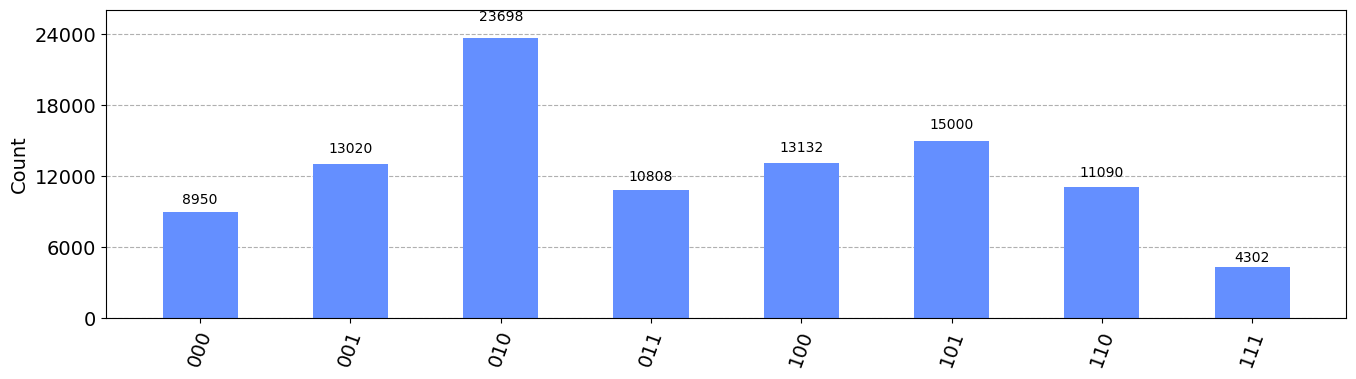

In [22]:
gamma=5
beta=3
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g5.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 4.550203367561669 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 2.6682431005077722


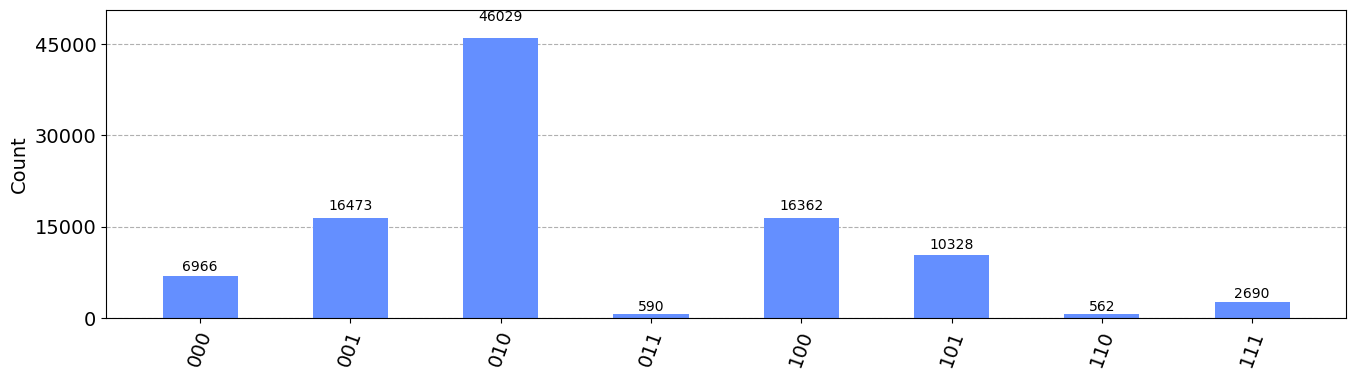

In [23]:
gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts,figsize=(16,4))

# Testing on fake noisy backend

In [24]:
simualtor = FakeToronto()

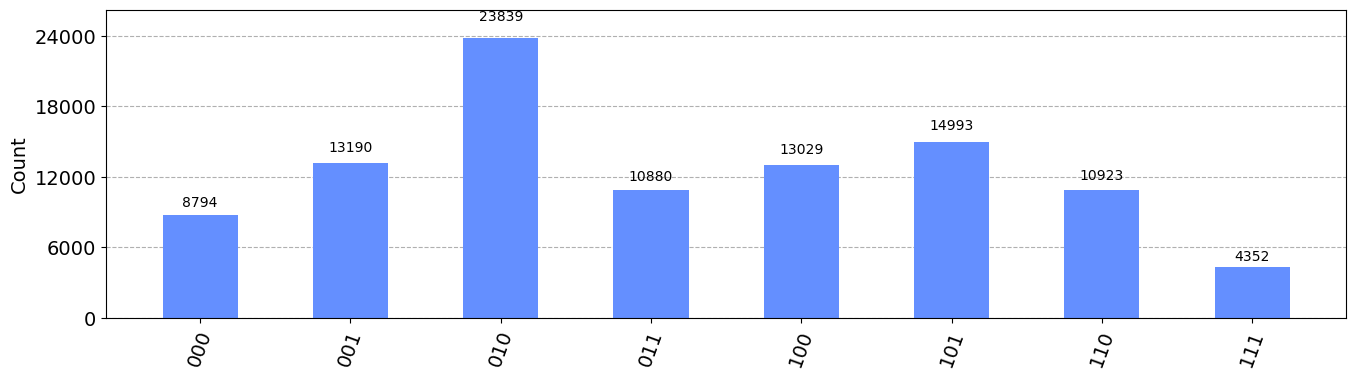

In [25]:
# 3 qubit
gamma=5
beta=3
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g5.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 5 ,Gamma Post-Otimization: 4.564199962963626 ,Beta Pre-Otimization: 3 ,Beta Post-Optimization: 2.7741216439153593


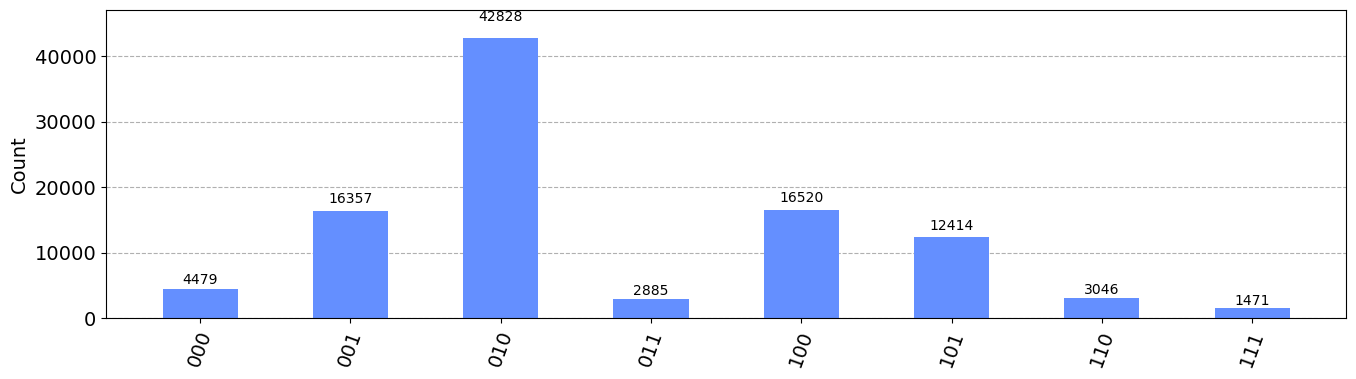

In [26]:
gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts,figsize=(16,4))

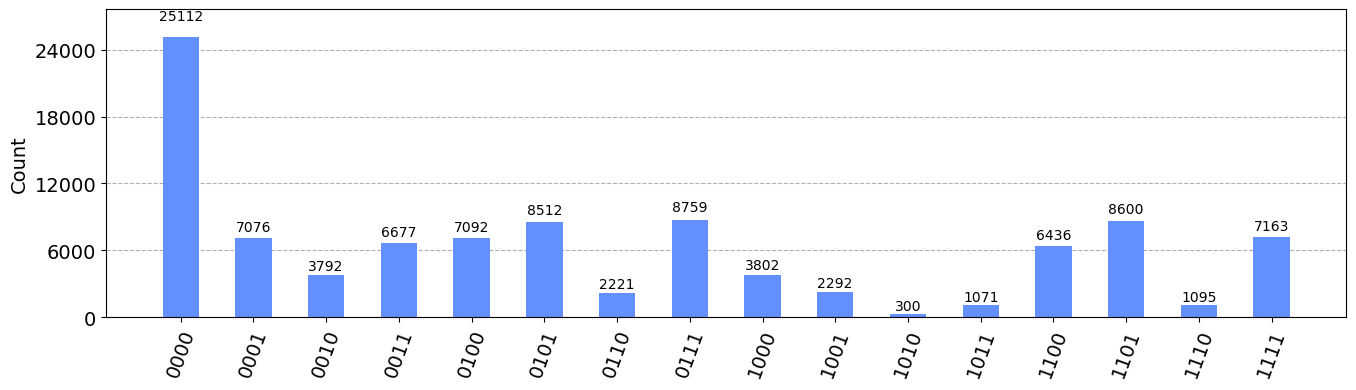

In [27]:
# 4 qubit
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g3.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 0.9734266468409659 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.9834835726341173


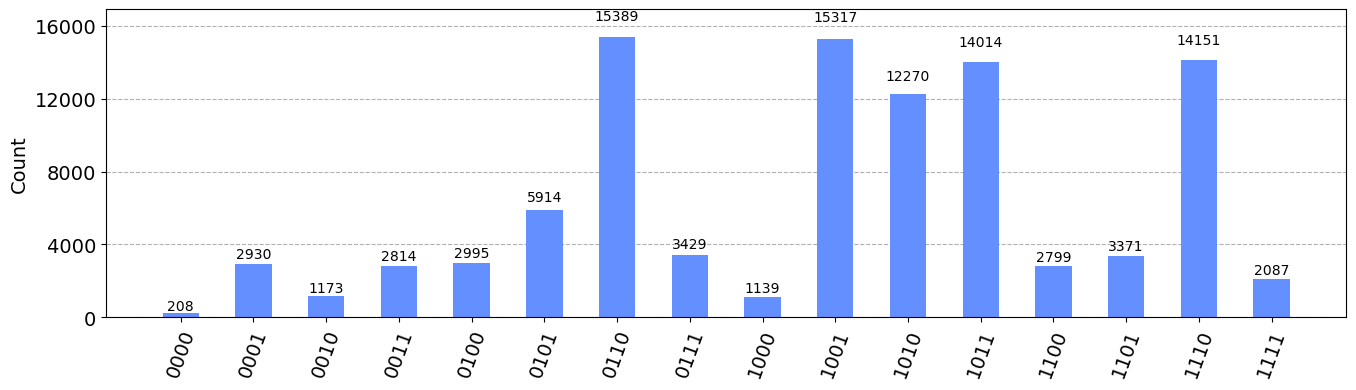

In [28]:
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g3, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

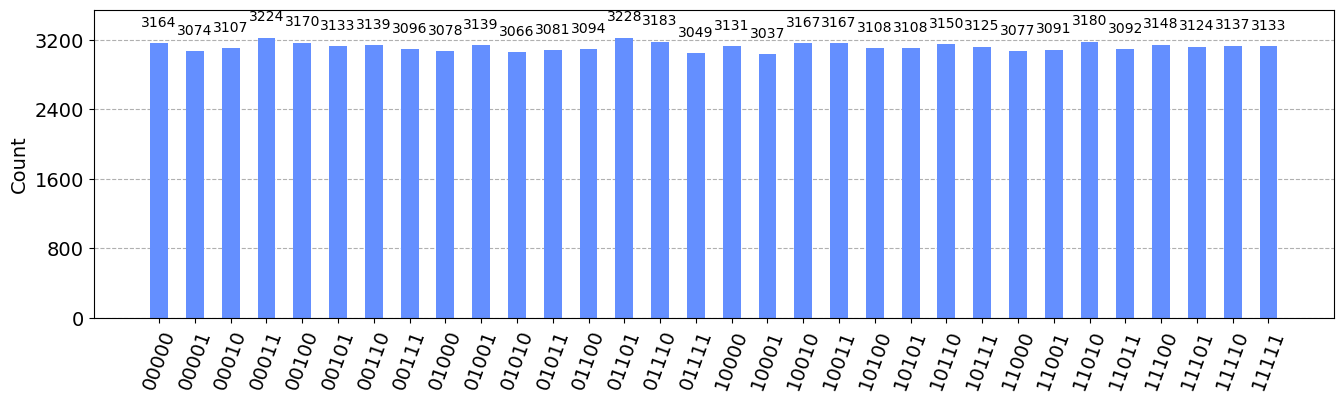

In [29]:
# 5 qubit
gamma=0
beta=0
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(connections,gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 0 ,Gamma Post-Otimization: -0.6383612478640296 ,Beta Pre-Otimization: 0 ,Beta Post-Optimization: 1.2975856510330968


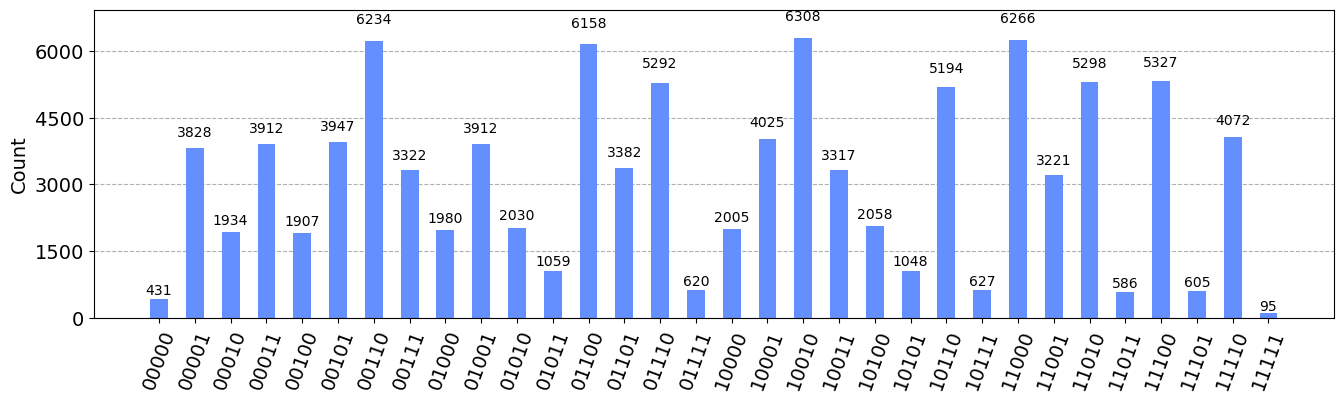

In [30]:
gamma=0
beta=0
theta = [gamma, beta]
expectation = get_expectation(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

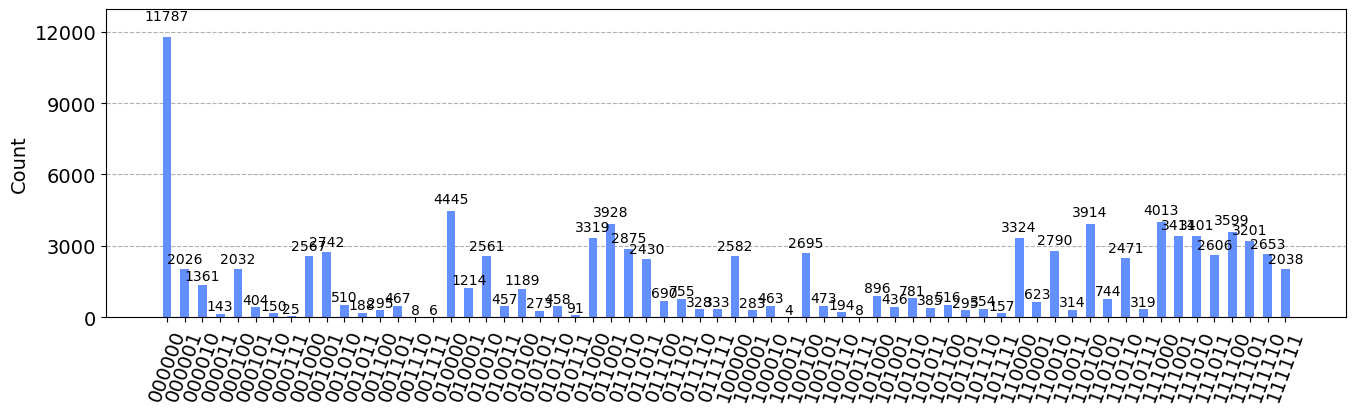

In [31]:
# 6 qubit
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g4.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, figsize=(16,4))

Gamma Pre-Otimization: 1 ,Gamma Post-Otimization: 2.2811234840811516 ,Beta Pre-Otimization: 1 ,Beta Post-Optimization: 1.98759175486246


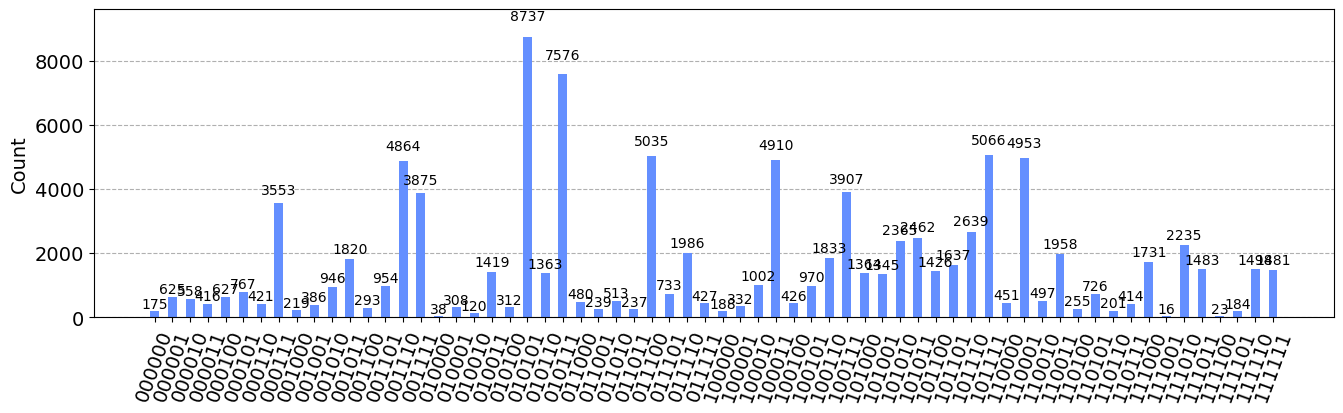

In [32]:
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots=100000).result().get_counts()
plot_histogram(counts,figsize=(16,4))

# Testing on IBM quantum computer

In [37]:
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 7 and 
                                        not x.configuration().simulator and x.status().operational==True))
shots = backend.configuration().max_shots
print(backend)
print(shots)

ibm_oslo
20000


Job Status: job has successfully run


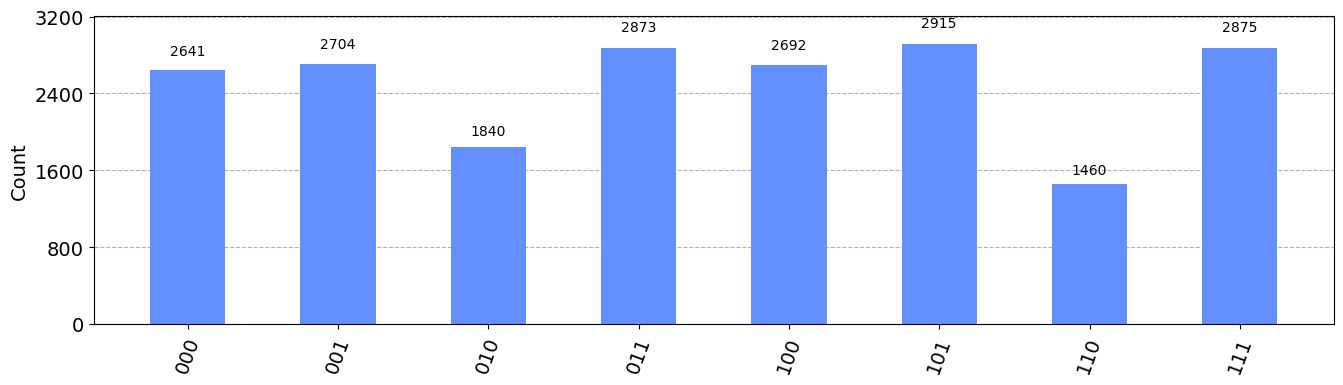

In [39]:
# 3 qubit
gamma=5
beta=3
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g5.getEdges(),gamma,beta)

circ = transpile(qc, backend, optimization_level=3)

# Run and get counts
job = backend.run(circ,shots = shots)
job_monitor(job)
counts = job.result().get_counts()
plot_histogram(counts, figsize=(16,4))

In [ ]:
gamma=5
beta=3
theta = [gamma, beta]
expectation = get_expectation(g5, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g5.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots).result().get_counts()
plot_histogram(counts,figsize=(16,4))

In [ ]:
# 4 qubit
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g3.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots).result().get_counts()
plot_histogram(counts, figsize=(16,4))

In [ ]:
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g3, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g3.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots).result().get_counts()
plot_histogram(counts, figsize=(16,4))

In [ ]:
# 5 qubit
gamma=0
beta=0
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(connections,gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots).result().get_counts()
plot_histogram(counts, figsize=(16,4))

In [ ]:
gamma=0
beta=0
theta = [gamma, beta]
expectation = get_expectation(g, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(connections,res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots).result().get_counts()
plot_histogram(counts, figsize=(16,4))

In [ ]:
# 6 qubit
gamma=1
beta=1
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(g4.getEdges(),gamma,beta)

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots).result().get_counts()
plot_histogram(counts, figsize=(16,4))

In [ ]:
gamma=1
beta=1
theta = [gamma, beta]
expectation = get_expectation(g4, backend)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma Pre-Otimization:", gamma, ",Gamma Post-Otimization:", res.x[0], ",Beta Pre-Otimization:", beta, ",Beta Post-Optimization:", res.x[1])

qc=QAOA_Vertex_Cover(g4.getEdges(),res.x[0],res.x[1])

circ = transpile(qc, backend)

# Run and get counts
counts = backend.run(circ,shots).result().get_counts()
plot_histogram(counts,figsize=(16,4))
